# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [188]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [189]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data["income"].value_counts()[">50K"]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data["income"].value_counts()["<=50K"]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100.0 * n_greater_50k / n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

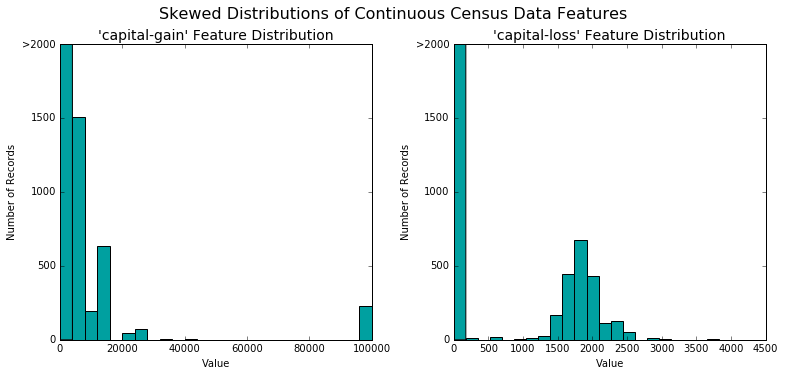

In [190]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

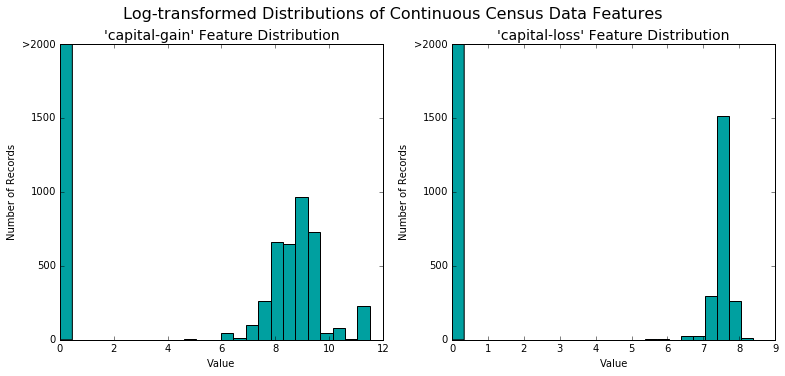

In [191]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [192]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [198]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)
#print features.head()

# TODO: Encode the 'income_raw' data to numerical values
#print income_raw.head(10)
#income = income_raw.copy()
#income[income_raw == "<=50K"] = 0
#income[income_raw == ">50K"] = 1
#print income.head(10)

#Original used above code to create income which looked liked it worked but gave issues with shape later on.
#It seems it created income as object rather than int.
#From forums (https://discussions.udacity.com/t/implementation-creating-a-training-and-predicting-pipeline/197273/28)
#found following code using lambda function and now creates income with ints and works correctly

income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)
print income.head(10)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64
103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marit

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [194]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [195]:
# TODO: Calculate accuracy
accuracy = 1.0 * n_greater_50k / n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
recall = 1 #Since no negatives
precision = accuracy #NB: This is not always true, but is correct in this case since we are always predicting positive
fscore = (1.0 + beta * beta) * (precision * recall) / (beta * beta * precision + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

1) KNeighbors
   It can be used for pattern recognition from CCTV cameras to detect theft in shops (http://www.dummies.com/programming/big-data/data-science/solving-real-world-problems-with-nearest-neighbor-algorithms/)
   Its main strengths are its simplicity and powerfulness. It can give good results without having to train a load of different parameters.
   Its main weakness is that it has to look at all the data everytime so can be slow and expensive, especially for large data sets with many dimensions. (https://ocw.mit.edu/courses/sloan-school-of-management/15-097-prediction-machine-learning-and-statistics-spring-2012/lecture-notes/MIT15_097S12_lec06.pdf)
   I will start with KNN due to its simplicity - it should give a good baseline result without a huge amount of effort and will be a good comparison for future algorithms. Also, the main weakness is not such an issue in this case since the algorithm will only be run a few time locally, as opposed to cases such as an online service where many people will call it many times and hence speed and efficiency is more important. If it proves there are too many dimensions to work well I can always go back and try a different algorithm.
   
   
2) Decision Trees
   It can be used for detecting credit card fraud (http://web.cs.ucdavis.edu/~vemuri/classes/ecs271/lecture3.pdf)
   Its main strengths are that it is easy to understand and has good noise immunity.
   One weakness is that is can be prone to overfitting if we are not careful. This risk can be reduced for example using pruning and/or limiting the number of nodes.
   The data has both numerical and categorical data and this is one area Decision Trees can be helpful. Also since they create a model of what they have learned it may help give me some further insights into the data which could be helpful when doing future analysis. Hence I will try this one second.
   
3) Gaussian Naive Bayes
   It is often used for detecting email spam (https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering).
   Its strengths are that it is easy to implement and can get good results even with small amounts of data http://www.slideshare.net/ashrafmath/naive-bayes-15644818).
   Its weakness is that it assumes class independence amongst variables and this may not always be true. This also means that it is not able to learn patterns which relate to combinations of features, e.g. "e.g., it can’t learn that although you love movies with Brad Pitt and Tom Cruise, you hate movies where they’re together" - (http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/)
   I will try Gaussian Naive Bayes third, again mainly because it is quick and simple to give good results. Howver it is probably not true that all variables are truely independent of each other (e.g. education_level and education-num, etc), but generally Naive Bayes should still give good results.
   

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [196]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    #print sample_size
    #print X_train[:sample_size]
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    #print X_train
    #print y_train
    #learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

KNeighborsClassifier trained on 452 samples.
KNeighborsClassifier trained on 4522 samples.
KNeighborsClassifier trained on 45222 samples.
DecisionTreeClassifier trained on 452 samples.
DecisionTreeClassifier trained on 4522 samples.
DecisionTreeClassifier trained on 45222 samples.
GaussianNB trained on 452 samples.
GaussianNB trained on 4522 samples.
GaussianNB trained on 45222 samples.


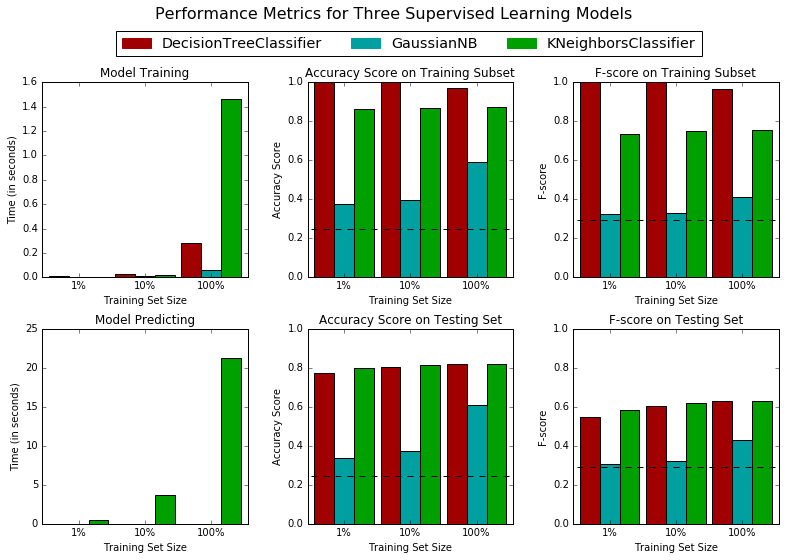

In [197]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# TODO: Initialize the three models
clf_A = KNeighborsClassifier()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(n_records * 0.01) #require whole number of samples so cast as int
samples_10 = int(n_records * 0.1)
samples_100 = int(n_records)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **
I believe that CharityML should use the Decision Tree model for their analysis. The most important performance metrics to consider are the accuracy score and in particular the F-score on Testing Set. In both cases GaussianNB performs quite poorly so it is easy decision to eliminate this one from consideration. Decision Trees and KNN perform well and both give very similar scores. When using only a small subset of the training set KNN performs slightly better, but by the time 100% of the data is used they are almost exactly the same. However KNN has one downside - as predicted earlier could be the case because of the large number of dimensions - that it runs significantly more slowly, both for training and prediction, than either Decision Trees or GausianNB. Thus on balance it seems to make more sense to use Decision Trees. Since they execute much more quickly, it should be easier to try more optimisation techniques and hence improve its score even further, whereas it may take a lot of processing time with KNN. Thus in the end Decision Trees should run much faster and even get the best scores.

In terms of downsides to Decision Trees I mentioned earlier they can be prone to overfitting. In this case the accuracy and f-scores on training data are very high - even 1 in several cases. This suggests overfitting. But this is probably not a problem of unsuitability to the data and should be able to be improved by tuning some parameters. Thus I don't see any objections to recommendation Decision Trees to CharityML.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
A good analogy for a Decision Tree is that it works like a flowchart. During the training process the aim is to make this flowchart, a series of questions that ask questions in turn about the data and hence split it into smaller and smaller subcategories which can then be classified (in this case as to whether someone is likely to donate or not). By using all the training samples the model can determine good questions to ask to efficiently and accurately classify the data.

Once the model has been made it is an easier process to make a prediction. Starting at the top of the flowchart the model asks the question of the point to predict, for example whether age is >30. Depending on the answer to this question the flowchart then splits of in 2 directions, one for yes and one for no (NB: in practice we can ask more complicated questions that do not just have yes or no answers and that can branch out in more directions, but for now we keep things simple).  For each branch we reach then another node which asks another question about the data, e.g. whether education level > 10. The data is thus further split again, and this process continues until the algorithm decides it has enough information to classify the person correctly as to whether they are likely to donate or not. It is like the game "20 Questions" where you have to think of something (person, object, etc) and then someone else has 20 questions to ask you to work out what thing you are thinking of.

Finally the algorithm returns the people which it thinks earn >50K and are hence most likely to donate.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [206]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'criterion' : ["gini", "entropy"],
              'max_depth' : [1,2,5,7,8,9,10,11,12,13,14,15,20,50,100, None]}
#initially ran with 1,2,5,10,20,50,100,None to get understanding of order of magnitude
#10 was best, so added more options around 10 to fine-tune

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print best_clf, "\n" #check what the best parameters actually were to allow further fine-tuning

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best') 

Unoptimized model
------
Accuracy score on testing data: 0.8187
F-score on testing data: 0.6282

Optimized Model
------
Final accuracy score on the testing data: 0.8524
Final F-score on the testing data: 0.7222


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |      0.8187       |     0.8524      |
| F-score        |      0.2917         |      0.6282       |     0.7222      |


**Answer: **
The results for even the unoptimised model for both accuracy and f-scores are signficantly higher than the original naive benchmark. This is proof that at least some learning is taken place from the data and that the algorithm is not just widely guessing and/or consistently predicting the same outcome each time.

Furthermore, the optimised model gives an additional boost in both accuracy and f-score compared to the unoptimised version. I found the best values for criterion (= gini) and max_depth (= 8) to give best performance. This will help CharityML to indentify even more people correctly.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them?_

**Answer:**

1) 'education-num' - in general the longer someone stayed in education the more likely they are to have a better job with bigger salary. I chose this category first, instead of the similar category 'education_level' as I predict the classifier may do a better job with continious numbered data as opposed to one-hot-encoded label data. For example it may be able to include that 11 years of education is better than 10, which is also better than 9, but without further information it won't necessarily know that Masters is better than Bachelors, which is better than Some-college, etc.

2) 'sex' - whilst not a good thing, and certainly not something I am advocating, sadly many studies have shown that women are consistently underpayed compared to men doing the same jobs, so it is likely we will see men having higher salaries here.

3) 'age' - in general the older someone is the more likely they are to earn more money (although there will be a sharp cut-off at some point around retirement age ~60-65)

4&5) 'capital-gain' & 'capital-loss' - these features relate directly towards financial metrics, so we may well see that those with higher capital-gain and can manage their money well also have high salaries, and vice-versa for those have high capital-loss. However there are many people in this census data who we don't have information for about these, so they may prove less significant and hence I put them last.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

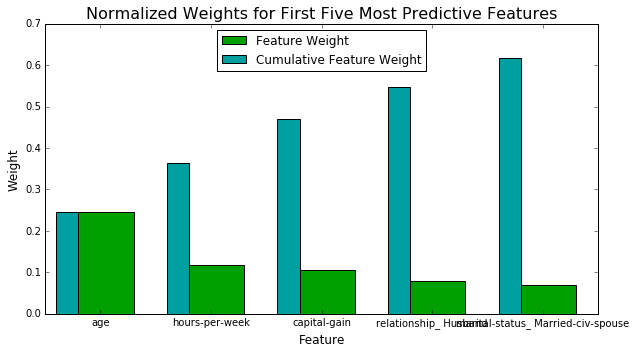

In [207]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# TODO: Train the supervised model on the training set 
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
I was correct that age and capital-gain are important features to consider, but incorrect about the others. Education-num and sex which I thought would be most important features didn't even appear in the top 5 at all!

Hours-per-week being second is not massively suprising and one I may have overlooked. It would make sense that people who work longer hours (e.g. at a full-time job) would earn more money than people who work shorter hours (e.g. a part-time job).

The fourth and fifth most important items, being a husband and being married are obviously linked to each other. The part about being a husband may relate to my prior (unfortunate) predictions about sex being a important factor for salary. In terms of why being married is important I imagine this is more of a correlation rather than causation. For one people who are married are more likely to be older and hence this could be a good proxy for the most important attribute, age. Also perhaps more successful people with a good salary could be considered more attractive to potential mates and hence more likely to get married in the first place!

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [208]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8524
F-score on testing data: 0.7222

Final Model trained on reduced data
------
Accuracy on testing data: 0.8157
F-score on testing data: 0.6205


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**
The accuracy and f-score using the reduced feature set decreases, but not by a hugely significant amount. In fact the new scores are very similar to the original unoptimised model using the full data set.

If training time was a factor then yes, it could be considered to trade-off some accuracy to be able to run faster. However in this case it doesn't take a very long time to run even with full feature space and anyway CharityML only needs to run this algorithm once / occasionally so I would recommend they went for the better performing version instead of speed.

Another interesting thing to try might be to run KNN on this reduced feature set version. It gave similar or very slightly higher scores than the Decision Tree, but with significantly slower speed due to high feature space. With the new data it may be able to run faster and after optimisation it could potentially give better performance than the Decision Tree.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.